##### Copyright 2020 The TensorFlow Probability Authors.


In [ ]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Windowed turnkey sampling in TFP

This notebook demonstrates putting together a `sample_model` function that implements [Stan's windowed adaptation algorithm](https://mc-stan.org/docs/2_19/reference-manual/hmc-algorithm-parameters.html). 

The sampling done by `sample_model` is similar in quality to that done by PyMC3 or Stan (each of those uses NUTS, not HMC, and I did not do any deep parameter searching for good integration lengths).

This incidentally shows how to run inference with hundreds of chains.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/discussion/examples/windowed_sampling.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/discussion/examples/windowed_sampling.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
!pip install -Uq tf-nightly tfp-nightly arviz

In [ ]:
# @title Imports
from collections import namedtuple
import warnings
import time

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.mcmc.internal import util as mcmc_util
from tensorflow_probability.python.internal import unnest

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64
az.style.use('arviz-darkgrid')

In [ ]:
# @title Helper functions

def get_flat_unconstraining_bijector(jd_model, initial_position, batch_rank):
  unconstraining_bij = jd_model.experimental_default_event_space_bijector()
  # First take the constrained space, and unconstrain it:
  bijectors = [unconstraining_bij]

  # In case of a JDNamed, pack the state_parts into a dictionary
  if isinstance(initial_position, dict):
    bijectors.append(tfb.Invert(tfb.Restructure(list(initial_position.keys()))))

  # Easiest to do a transform here instead of casing for dictionaries again.
  list_position = tfb.Chain(bijectors[-1::-1])(initial_position)
  # This bijector takes flat tensors shapes and reshapes them to proper shape
  bijectors.append(tfb.JointMap(
          [tfb.Reshape(ps.shape(x)[batch_rank:]) for x in list_position]))

  # This splits a single tensor into state_parts
  bijectors.append(tfb.Split(
        num_or_size_splits=np.asarray(
            [ps.reduce_prod(ps.shape(x)[batch_rank:]) for x in list_position]
            ).flatten(),
        axis=-1))
  
  # Notice that we want to apply the bijectors in the opposite order
  return tfb.Invert(tfb.Chain(bijectors))

MCMCState = namedtuple("MCMCState", ['pinned_model', 
                                     'initial_position',
                                     'initial_transformed_position',
                                     'bijector', 
                                     'batch_rank',
                                     'batch_shape',
                                     'target_log_prob_fn'])

def setup_mcmc(model, n_chains, **pins):
  pinned_model = model.experimental_pin(**pins)
  # TODO: add argument to `sample_unpinned` to get chains
  initial_position = pinned_model.sample_unpinned(n_chains)
  target_log_prob_val = pinned_model.unnormalized_log_prob(initial_position)
  batch_rank = ps.rank(target_log_prob_val)
  batch_shape = ps.shape(target_log_prob_val)

  bijector = get_flat_unconstraining_bijector(pinned_model, 
                                              initial_position, 
                                              batch_rank)
  initial_transformed_position = bijector.forward(initial_position)

  # Jitter init
  initial_transformed_position = tfd.Uniform(-2., 2.).sample(
      initial_transformed_position.shape)
  initial_position = bijector.inverse(initial_transformed_position)

  target_log_prob_fn = lambda x: pinned_model.unnormalized_log_prob(bijector.inverse(x)) + bijector.inverse_log_det_jacobian(x, event_ndims=1)
  # target_log_prob_fn = pinned_model.unnormalized_log_prob
  
  return MCMCState(pinned_model=pinned_model,
                   initial_position=initial_position,
                   initial_transformed_position=initial_transformed_position,
                   bijector=bijector,
                   batch_rank=batch_rank,
                   batch_shape=batch_shape,
                   target_log_prob_fn=target_log_prob_fn)
  

def make_base_kernel(mcmc_state, *, 
                     step_size, 
                     num_leapfrog_steps, 
                     momentum_distribution):
  return tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(
          mcmc_state.target_log_prob_fn, step_size=step_size,
          num_leapfrog_steps=num_leapfrog_steps, 
          momentum_distribution=momentum_distribution)


def make_fast_adapt_kernel(mcmc_state, *, 
                           initial_step_size, 
                           num_leapfrog_steps, 
                           num_adaptation_steps, 
                           target_accept_prob=0.75, 
                           momentum_distribution=None):
  return tfp.mcmc.SimpleStepSizeAdaptation(
      make_base_kernel(mcmc_state, 
                       step_size=initial_step_size, 
                       num_leapfrog_steps=num_leapfrog_steps, 
                       momentum_distribution=momentum_distribution), 
      num_adaptation_steps=num_adaptation_steps, 
      target_accept_prob=target_accept_prob)
  

def make_slow_adapt_kernel(mcmc_state, *, 
                           initial_running_variance, 
                           initial_step_size, 
                           num_leapfrog_steps, 
                           num_adaptation_steps, 
                           target_accept_prob=0.75):
  return tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(
      make_fast_adapt_kernel(mcmc_state, 
                             initial_step_size=initial_step_size, 
                             num_leapfrog_steps=num_leapfrog_steps,
                             num_adaptation_steps=num_adaptation_steps,
                             target_accept_prob=target_accept_prob),
      initial_running_variance=initial_running_variance)

In [ ]:
# @title Kernels

@tf.function(jit_compile=True)
def fast_window(mcmc_state, num_leapfrog_steps, *, 
                num_draws, 
                initial_position,
                initial_step_size,
                momentum_distribution=None):
  kernel = make_fast_adapt_kernel(
      mcmc_state, 
      initial_step_size=initial_step_size, 
      num_leapfrog_steps=num_leapfrog_steps,
      num_adaptation_steps=num_draws, 
      momentum_distribution=momentum_distribution)
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    draws, _, fkr =  tfp.mcmc.sample_chain(num_draws, initial_position, 
                                          kernel=kernel, 
                                          return_final_kernel_results=True, 
                                          trace_fn=None)
  weighted_running_variance = tfp.experimental.stats.RunningVariance.from_stats(
      num_samples=num_draws / 2, 
      mean=tf.reduce_mean(draws[-num_draws // 2:], 
                          axis=ps.range(mcmc_state.batch_rank+1)),
      variance=tf.math.reduce_variance(draws[-num_draws // 2:], 
                                       axis=ps.range(mcmc_state.batch_rank+1)))

  step_size = unnest.get_innermost(fkr, 'step_size')
  return draws[-1], step_size, weighted_running_variance 

  
@tf.function(jit_compile=True)
def slow_window(mcmc_state, num_leapfrog_steps, *, 
                num_draws, 
                initial_position, 
                initial_running_variance, 
                initial_step_size):

  kernel = make_slow_adapt_kernel(
      mcmc_state, 
      initial_running_variance=initial_running_variance,
      initial_step_size=initial_step_size, 
      num_leapfrog_steps=num_leapfrog_steps,
      num_adaptation_steps=num_draws)
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    draws, _, fkr = tfp.mcmc.sample_chain(num_draws, initial_position, 
                                          kernel=kernel, 
                                          return_final_kernel_results=True, 
                                          trace_fn=None)
  weighted_running_variance = tfp.experimental.stats.RunningVariance.from_stats(
    num_samples=num_draws / 2, 
    mean=tf.reduce_mean(draws[-num_draws // 2:], 
                        axis=ps.range(mcmc_state.batch_rank+1)),
    variance=tf.math.reduce_variance(draws[-num_draws // 2:], 
                                      axis=ps.range(mcmc_state.batch_rank+1)))

  step_size = unnest.get_innermost(fkr, 'step_size')
  momentum_distribution = unnest.get_outermost(fkr, 'momentum_distribution') 

  return draws[-1], step_size, weighted_running_variance, momentum_distribution

@tf.function(jit_compile=True)
def do_sampling(mcmc_state, num_leapfrog_steps, *,
                num_draws,
                initial_position,
                step_size,
                momentum_distribution,
                trace_fn=None):
  kernel = make_base_kernel(mcmc_state, 
                            step_size=step_size,
                            num_leapfrog_steps=num_leapfrog_steps,
                            momentum_distribution=momentum_distribution)
  return tfp.mcmc.sample_chain(num_draws, initial_position, 
                               kernel=kernel, 
                               trace_fn=trace_fn)


In [ ]:
# @title Implementation of `sample_model`

def sample_model(n_draws, joint_dist, *, 
                 n_chains=16, 
                 num_leapfrog_steps=8,
                 trace_fn=None, 
                 **pins):

  mcmc_state = setup_mcmc(joint_dist, n_chains=n_chains, **pins)
  fast_window_size = 75
  slow_window_size = 25

  print(f"Fast window {fast_window_size}")
  position, step_size, running_variance = fast_window(
      mcmc_state, num_leapfrog_steps,
      num_draws=fast_window_size,
      initial_position=mcmc_state.initial_transformed_position,
      initial_step_size=tf.ones(mcmc_state.batch_shape)[..., tf.newaxis])

  for idx in range(4):
    window_size = slow_window_size * (2 ** idx)

    print(f"Slow window {window_size}")
    position, step_size, running_variance, momentum_distribution = slow_window(
        mcmc_state, num_leapfrog_steps,
        num_draws=window_size,
        initial_position=position,
        initial_running_variance=running_variance,
        initial_step_size=step_size)

  print(f"Fast window {fast_window_size}")
  position, step_size, running_variance = fast_window(
      mcmc_state, num_leapfrog_steps,
      num_draws=fast_window_size,
      initial_position=position,
      initial_step_size=step_size,
      momentum_distribution=momentum_distribution)

  print(f"main draws {n_draws}")
  draws = do_sampling(mcmc_state, num_leapfrog_steps,
                      num_draws=n_draws,
                      initial_position=position,
                      step_size=step_size,
                      momentum_distribution=momentum_distribution,
                      trace_fn=trace_fn)
  return mcmc_state.bijector.inverse(draws), mcmc_state

# Usage example: Eight schoools

In [ ]:
# @title Write down model

num_schools = 8  # number of schools
treatment_effects = tf.constant([28., 8, -3, 7, -1, 1, 18, 12])    # treatment effects
treatment_stddevs = tf.constant([15., 10, 16, 11, 9, 11, 10, 18])  # treatment SE


eight_schools = tfd.JointDistributionSequential([
  tfd.Normal(0., 5., name='avg_effect'),
  tfd.HalfNormal(5., name='avg_stddev'),
  tfd.Independent(tfd.Normal(loc=tf.zeros(num_schools),
                             scale=tf.ones(num_schools)), 
                  reinterpreted_batch_ndims=1,
                  name='school_effects_std'),
  lambda school_effects_std, avg_stddev, avg_effect: tfd.Independent(
      tfd.Normal(loc=(avg_effect[..., tf.newaxis] + 
                      avg_stddev[..., tf.newaxis] * school_effects_std),
      scale=treatment_stddevs), 
      reinterpreted_batch_ndims=1,
      name='treatment_effects') 
])

## Windowed sampling

In [ ]:
%time draws, mcmc_state = sample_model(500, eight_schools, n_chains=64, treatment_effects=treatment_effects)

Fast window 75
Slow window 25
Slow window 50
Slow window 100
Slow window 200
Fast window 75
main draws 500
CPU times: user 43.7 s, sys: 557 ms, total: 44.3 s
Wall time: 44.4 s


## Compare results with NUTS sampling of the same model

In [ ]:
draws_dict = {k[0]: tf.einsum('ij...->ji...', v) for v, k in zip(draws, eight_schools.resolve_graph())}
idata = az.from_dict(posterior=draws_dict)
idata

Inference data with groups:
	> posterior

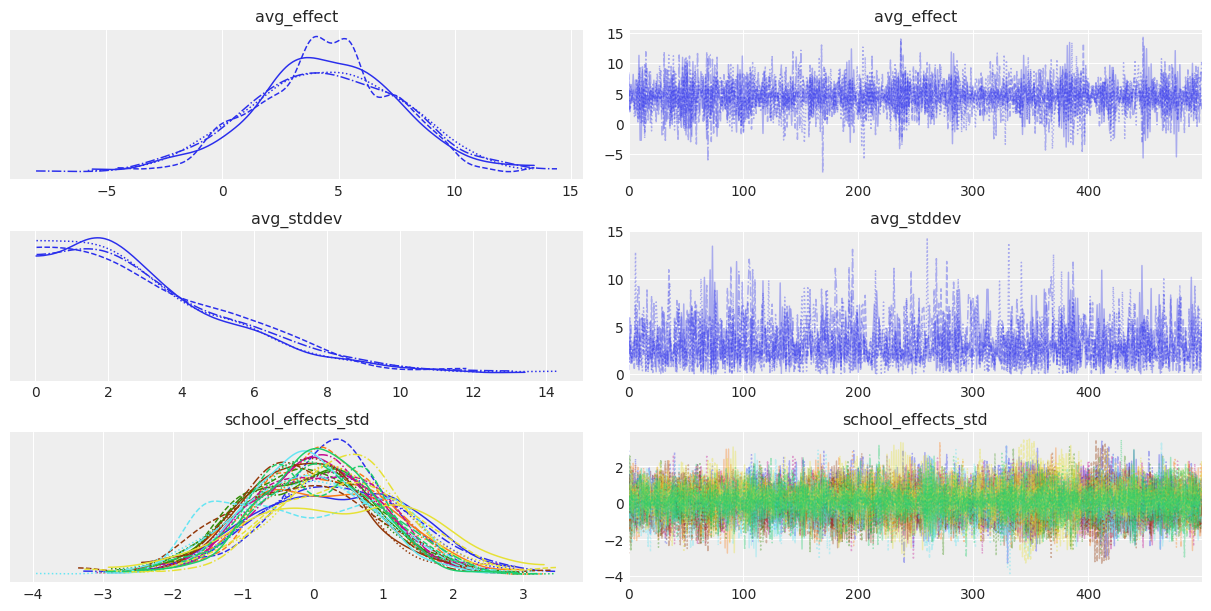

In [ ]:
# Only plotting the first 4 chains
az.plot_trace(idata.sel(chain=[0, 1, 2, 3]), combined=False, compact=True);

In [ ]:
# @title TFP Results
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
avg_effect,4.445,3.227,-1.634,10.531,0.020,0.018,25183.0,16096.0,25111.0,16020.0,1.01
avg_stddev,3.330,2.519,0.000,7.847,0.018,0.014,20710.0,15395.0,26998.0,16036.0,1.00
school_effects_std[0],0.314,0.985,-1.540,2.144,0.007,0.009,18649.0,5716.0,18583.0,11180.0,1.01
school_effects_std[1],0.092,0.955,-1.751,1.851,0.006,0.009,25276.0,6109.0,25338.0,13053.0,1.01
school_effects_std[2],-0.088,0.952,-1.822,1.762,0.005,0.010,30306.0,4443.0,30298.0,14300.0,1.01
school_effects_std[3],0.056,0.941,-1.677,1.878,0.005,0.010,36250.0,4021.0,36117.0,11667.0,1.01
school_effects_std[4],-0.169,0.930,-1.940,1.559,0.006,0.008,23681.0,6330.0,23750.0,13245.0,1.01
school_effects_std[5],-0.076,0.952,-1.847,1.708,0.006,0.009,29886.0,5374.0,29891.0,13012.0,1.01
school_effects_std[6],0.356,0.964,-1.462,2.164,0.006,0.009,23934.0,6346.0,23924.0,13831.0,1.01
school_effects_std[7],0.065,0.975,-1.780,1.908,0.007,0.013,17462.0,2857.0,17581.0,4372.0,1.01


In [ ]:
# @title PyMC3 NUTS results
data = az.load_arviz_data("non_centered_eight")
az.summary(data, var_names=['mu', 'tau', 'theta_t'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,4.494,3.286,-2.187,10.201,0.068,0.053,2344.0,1896.0,2354.0,1401.0,1.00
tau,3.447,2.915,0.003,8.603,0.074,0.052,1556.0,1556.0,1268.0,900.0,1.00
theta_t[0],0.338,0.997,-1.587,2.112,0.021,0.023,2216.0,955.0,2215.0,1450.0,1.00
theta_t[1],0.108,0.923,-1.665,1.734,0.017,0.022,3109.0,900.0,3159.0,1514.0,1.00
theta_t[2],-0.087,0.948,-1.799,1.661,0.018,0.023,2911.0,871.0,2926.0,1530.0,1.00
theta_t[3],0.092,0.976,-1.762,1.908,0.019,0.025,2524.0,783.0,2515.0,1237.0,1.00
theta_t[4],-0.194,0.940,-1.900,1.512,0.020,0.022,2289.0,931.0,2313.0,1487.0,1.00
theta_t[5],-0.044,0.954,-1.902,1.610,0.019,0.023,2560.0,839.0,2553.0,1464.0,1.00
theta_t[6],0.312,0.956,-1.609,2.070,0.018,0.021,2668.0,1004.0,2678.0,1207.0,1.00
theta_t[7],0.061,0.935,-1.620,1.794,0.019,0.021,2525.0,966.0,2522.0,1589.0,1.01


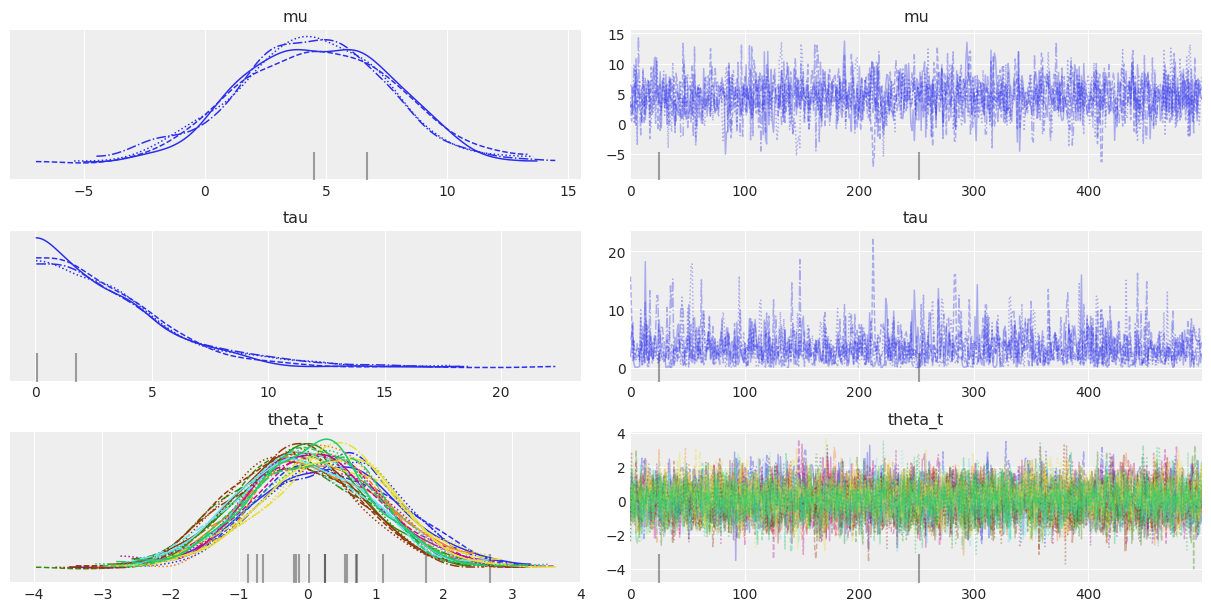

In [ ]:
az.plot_trace(data, var_names=['mu', 'tau', 'theta_t'], compact=True);

# Usage example: Linear regression

See [this github issue](https://github.com/tensorflow/probability/issues/1161) which references [this blog post](https://colcarroll.github.io/ppl-api/) for the setup here, and what the situation used to looked like. 

In [ ]:
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims).astype(np.float32)
w_ = np.random.randn(ndims).astype(np.float32)  # hidden
noise_ = 0.1 * np.random.randn(ndata).astype(np.float32)  # hidden

y_obs = X.dot(w_) + noise_

In [ ]:
# @title Write down model
linear_model = tfd.JointDistributionSequentialAutoBatched([
  tfd.Normal(tf.zeros(ndims), tf.ones(ndims), name='w'),
  lambda w: tfd.Normal(tf.linalg.matvec(X, w), 0.1, name='y')
])


## Windowed sampling

In [ ]:
%time draws, mcmc_state = sample_model(500, linear_model, n_chains=256, y=y_obs)

Fast window 75
Slow window 25
Slow window 50
Slow window 100
Slow window 200
Fast window 75
main draws 500
CPU times: user 42.9 s, sys: 583 ms, total: 43.4 s
Wall time: 43.6 s


## Analyze fit

In [ ]:
draws_dict = {k[0]: tf.einsum('ij...->ji...', v) for v, k in zip(draws, linear_model.resolve_graph())}
idata = az.from_dict(posterior=draws_dict)
idata

Inference data with groups:
	> posterior

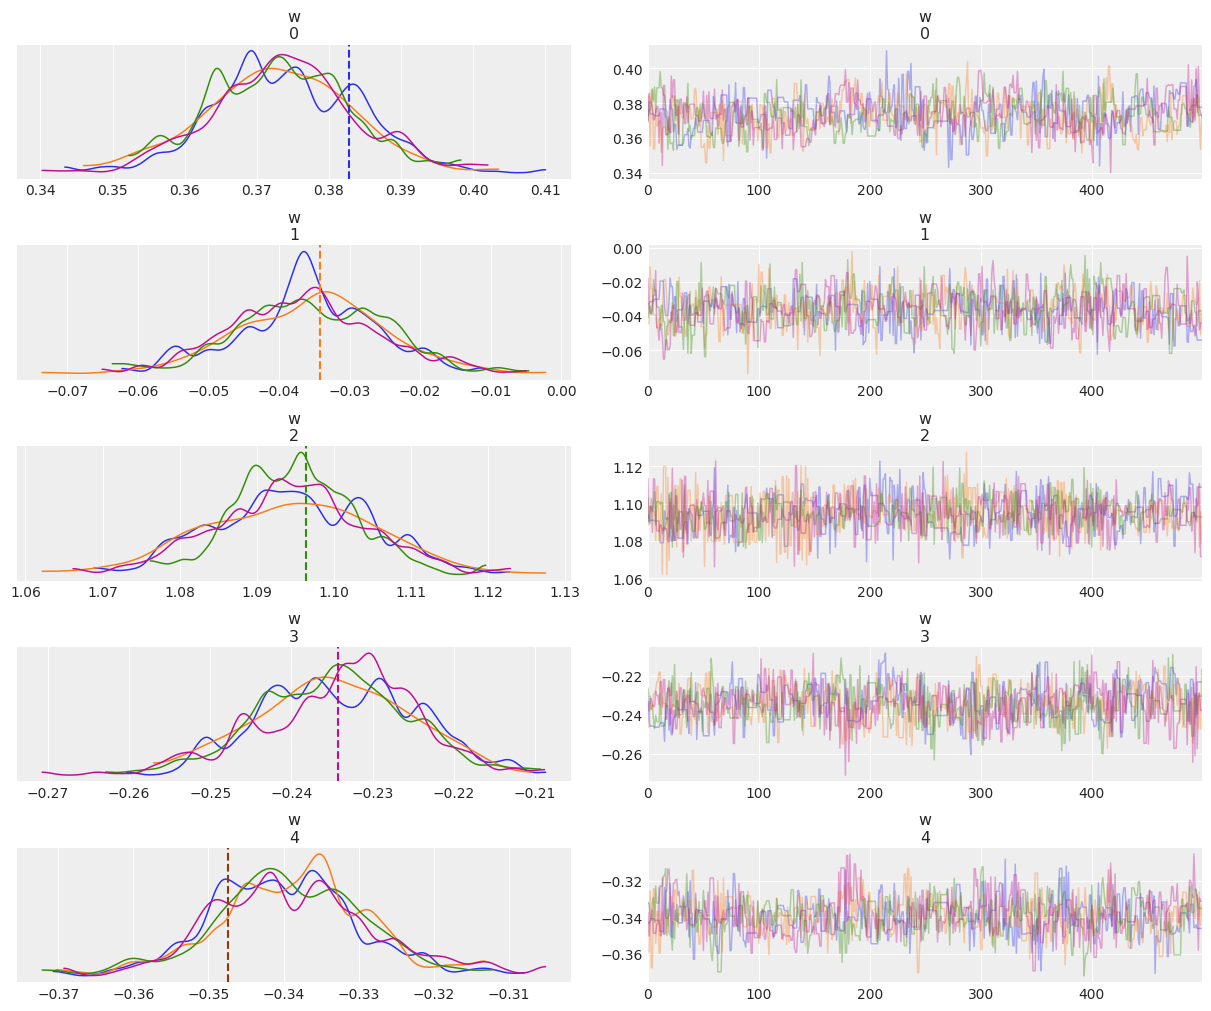

In [ ]:
# Only plotting the first 4 chains
axes = az.plot_trace(idata.sel(chain=[0, 1, 2, 3]))
for idx, (true_val, ax) in enumerate(zip(w_, axes)):
  ax[0].axvline(true_val, color=f'C{idx}', linestyle='dashed');

In [ ]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
w[0],0.373,0.010,0.354,0.391,0.0,0.0,3424.0,3424.0,3429.0,13667.0,1.05
w[1],-0.036,0.011,-0.055,-0.015,0.0,0.0,15409.0,15409.0,15426.0,36882.0,1.01
w[2],1.095,0.010,1.076,1.114,0.0,0.0,14131.0,14131.0,14139.0,26735.0,1.01
w[3],-0.234,0.010,-0.252,-0.216,0.0,0.0,5990.0,5988.0,5991.0,19865.0,1.03
w[4],-0.339,0.010,-0.359,-0.320,0.0,0.0,5707.0,5707.0,5708.0,23421.0,1.03
